## Pendahuluan

**Studi: Analisis Trip Pengguna Jasa Taksi**

Zuber, perusahaan ride-sharing di Chicago, ingin menganalisis preferensi penumpang dan dampak faktor eksternal pada perjalanan. Kita menggunakan SQL untuk mengumpulkan data dan Python untuk analisis EDA. Analisis kita meliputi:

**`SQL:`**

- Data perusahaan taksi terbanyak pada 15-16 November 2017.
- Jumlah perjalanan Kuning dan Biru pada 1-7 November 2017.
- Jumlah perjalanan Flash Cab dan Taxi Affiliation Services pada 1-7 November 2017.
- Data cuaca pada Sabtu perjalanan dari Loop ke O’Hare di November 2017.

**`Python:`**
- Perusahaan taksi terbanyak pada 15-16 November 2017.
- Distribusi jumlah perjalanan dari semua perusahaan pada 15-16 November 2017.
- Lokasi dropoff favorit pengguna selama November 2017.
- Distribusi rata-rata perjalanan di tiap lokasi dropoff selama November 2017.
- Menguji hipotesis: Perubahan durasi rata-rata perjalanan dari Loop ke Bandara O'Hare pada hari Sabtu yang hujan.

## Konten <a id='back'></a>

* [1.Pendahuluan](#intro)
* [2. Konten](#cont_3)
    * [2.1 Mengumpulkan Data Menggunakan SQL ](#cont_4)
      * [2.1.1 Web Scraping](#cont_8)
      * [2.1.2 Menghitung dan Mengurutkan Trip Berdasarkan Nama Perusahaan](#cont_14)
      * [2.1.3 Menghitung Jumlah Trip Berdasarkan Nama Perusahaan yang Menggunakan kata Yellow atau Blue](#cont_14)
      * [2.1.4 Menghitung Jumlah Trip untuk Nama Perusahaan Flash Cab dan Taxi Affiliation Services](#cont_14)
      * [2.1.5 Mengumpulkan Hasil Akhir Rekaman Cuaca](#cont_14)
    * [2.2 Mempersiapkan Datasets](#cont_15)
      * [2.2.1 Insialisasi Library](#cont_15)
      * [2.2.2 Mempersiapkan Dataset company_name](#cont_15)
      * [2.2.3 Mempersiapkan Dataset dropoff_location](#cont_15)
      * [2.2.4 Mempersiapkan Dataset weather](#cont_15)
    * [2.3 Memperbaiki Datasets](#cont_20)
      * [2.3.1 Mengecek Duplikat pada Datasets](#cont_8)
      * [2.3.2 Memperbaiki Kualitas Data pada Dataset company_name](#cont_14)
      * [2.3.3 Memperbaiki Kualitas Data pada Dataset dropoff_location](#cont_14)
      * [2.3.4 Memperbaiki Kualitas Data pada Dataset weather](#cont_14)
    * [2.4 Analisis Data Eksploratif (EDA)](#cont_22) 
      * [2.4.1 Analisis Dataset Perusahaan Taksi](#cont_22)
      * [2.4.2 Analisis Dataset Lokasi Dropoff](#cont_22)    
    * [2.5 Pengujian Hipotesis](#cont_23)
    * [2.6 Kesimpulan Umum](#cont_24)


### Mengumpulkan Data Menggunakan SQL

Kita akan menjelajahi beberapa kumpulan data yang berkorelasi: Neighborhoods, Cabs, Trips, dan Weather. Ini adalah ikhtisar fitur-fitur utama dalam setiap dataset:

**`Neighborhoods`**:
- `nama` (Nama Daerah)
- `neighborhood_id` (Kode Wilayah)

**`Cabs:`**
- `cab_id` (Kode Kendaraan)
- `vehicle_id` (Identitas Teknis Kendaraan)
- `company_name` (Nama Perusahaan)

**`Trips:`**
- `trip_id` (Identitas Trip)
- `cab_id` (Kode Kendaraan)
- `start_ts` (Waktu Awal Perjalanan)
- `end_ts` (Waktu Akhir Perjalanan)
- `duration_seconds` (Durasi Perjalanan, detik)
- `distance_miles` (Jarak Perjalanan, mil)
- `pickup_location_id` (Lokasi Penjemputan)
- `dropoff_location_id` (Lokasi Penurunan)

**`Weather:`**
- `record_id` (Kode Perekaman Cuaca)
- `ts` (Waktu Perekaman Cuaca)
- `suhu` (Suhu)
- `deskripsi` (Deskripsi Kondisi Cuaca)

Kami akan menggunakan dataset ini untuk membuat sebuah database relasional, dengan menghubungkan data dari satu dataset ke yang lain menggunakan primary key (PK) dan foreign key (FK).

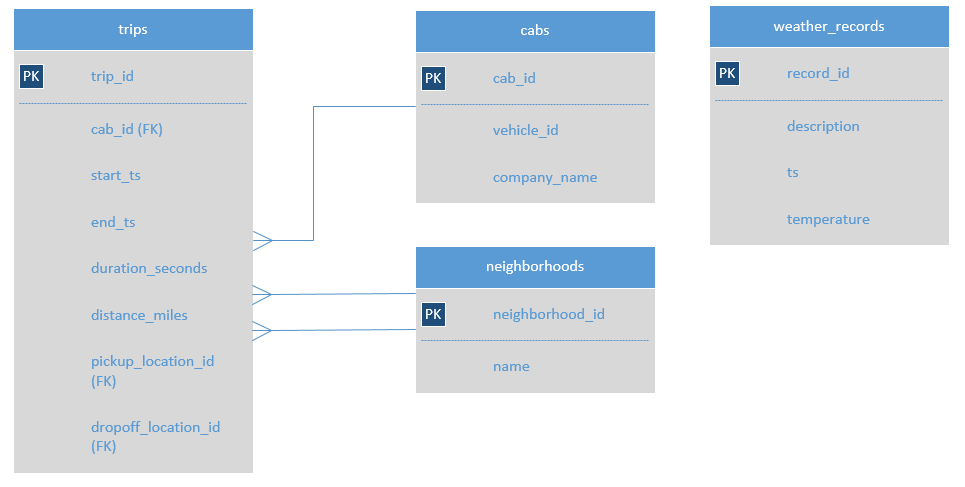

Source: tripleten.com

#### Web Scraping

Di bagian ini, kita akan melakukan scraping `weather_records` pada server dan mengubahnya menjadi Data Frame. Kita akan menggunakan `TripleTen Server` yang memiliki `weather_records` dengan menggunakan parameter `attrs={"id": "weather_records"}`.

In [32]:
# memuat modul
import requests
from bs4 import BeautifulSoup
import pandas as pd

In [33]:
# URL
URL='https://practicum-content.s3.us-west-1.amazonaws.com/data-analyst-eng/moved_chicago_weather_2017.html'

# meminta request ke server
req = requests.get(URL)
soup = BeautifulSoup(req.text)
table = soup.find('table', attrs={"id": "weather_records"})

# mengumpulkan data
heading_table=[]
for row in table.find_all('th'):
    heading_table.append(row.text)   
content=[]
for row in table.find_all('tr'):
    if not row.find_all('th'):
        content.append([element.text for element in row.find_all('td')])

# membuat data frame
weather_records = pd.DataFrame(content, columns = heading_table)
print(weather_records)

           Date and time Temperature       Description
0    2017-11-01 00:00:00     276.150     broken clouds
1    2017-11-01 01:00:00     275.700  scattered clouds
2    2017-11-01 02:00:00     275.610   overcast clouds
3    2017-11-01 03:00:00     275.350     broken clouds
4    2017-11-01 04:00:00     275.240     broken clouds
..                   ...         ...               ...
692  2017-11-29 20:00:00     281.340        few clouds
693  2017-11-29 21:00:00     281.690      sky is clear
694  2017-11-29 22:00:00     281.070        few clouds
695  2017-11-29 23:00:00     280.060      sky is clear
696  2017-11-30 00:00:00     278.460      sky is clear

[697 rows x 3 columns]


#### Menghitung dan Mengurutkan Trip Berdasarkan Nama Perusahaan

Kita akan menggunakan SQL untuk menghitung dan mengurutkan perjalanan dari kumpulan data `trips` dan `cabs`. Kita mengelompokkannya berdasarkan `company_name` dan mengurutkan hasilnya. Ini kodenya:

```SQL
SELECT
    cabs.company_name,
    COUNT(trips.trip_id) AS trips_amount
FROM 
    cabs
    INNER JOIN 
    trips 
    ON 
    trips.cab_id = cabs.cab_id
WHERE 
    CAST(trips.start_ts AS date) BETWEEN '2017-11-15' AND '2017-11-16'
GROUP BY 
    company_name
ORDER BY 
    trips_amount DESC;
```

Hasil:

```SQL
company_name	         trips_amount
Flash Cab	                19558
Taxi Affiliation Services	11422
Medallion Leasin	         10367
Yellow Cab	                9888
.
.
.
2733 - 74600 Benny Jona	7
5874 - 73628 Sergey Cab Corp.	5
2241 - 44667 - Felman Corp, Manuel Alonso	3
3556 - 36214 RC Andrews Cab	2
```

#### Menghitung Jumlah Trip Berdasarkan Nama Perusahaan yang Menggunakan kata Yellow atau Blue

Kami akan mencari nama perusahaan yang menggunakan kata `Yellow` atau `Blue` untuk DateTime antara `2017-11-01` dan `2017-11-07`. Ini kodenya:

```SQL
SELECT
    cabs.company_name as company_name,
    COUNT(trips.trip_id) AS trips_amount
FROM 
    cabs
INNER JOIN 
    trips 
ON 
    trips.cab_id = cabs.cab_id
WHERE 
    CAST(trips.start_ts AS date) BETWEEN '2017-11-01' AND '2017-11-07'
    AND cabs.company_name LIKE '%%Yellow%%'
GROUP BY company_name
UNION ALL
SELECT
    cabs.company_name as company_name,
    COUNT(trips.trip_id) AS trips_amount
FROM 
    cabs
INNER JOIN 
    trips 
ON 
    trips.cab_id = cabs.cab_id
WHERE 
    CAST(trips.start_ts AS date) BETWEEN '2017-11-01' AND '2017-11-07'
    AND cabs.company_name LIKE '%%Blue%%'
GROUP BY company_name;
```

Hasil:

```SQL
company_name	                 trips_amount
Taxi Affiliation Service Yellow	   29213
Yellow Cab	                        33668
Blue Diamond	                       6764
Blue Ribbon Taxi Association Inc.	 17675
```

#### Menghitung Jumlah Trip untuk Nama Perusahaan Flash Cab dan Taxi Affiliation Services

Kita akan mengatur nama perusahaan; jika bukan `Flash Cab` atau `Taxi Affiliation Services` akan menjadi `Other`. Kita akan menghitung DateTime antara `2017-11-01` dan `2017-11-07`. Ini kodenya:

```SQL
SELECT
    CASE 
        WHEN cabs.company_name = 'Flash Cab' THEN 'Flash Cab' 
        WHEN cabs.company_name = 'Taxi Affiliation Services' THEN 'Taxi Affiliation Services' 
        ELSE 'Other' 
    END AS company,
    COUNT(trips.trip_id) as trips_amount                
FROM 
    cabs
INNER JOIN 
    trips 
ON 
    trips.cab_id = cabs.cab_id
WHERE 
    CAST(trips.start_ts AS date) BETWEEN '2017-11-01' AND '2017-11-07'
GROUP BY 
    company
ORDER BY 
    trips_amount DESC;
```

Hasil:

```SQL
company	                 trips_amount
Other	                      335771
Flash Cab	                   64084
Taxi Affiliation Services	   37583
```

#### Mengumpulkan Hasil Akhir Rekaman Cuaca

Kita akan mengumpulkan data untuk kasus `jika hujan pada hari Sabtu berpengaruh atau tidak` untuk perjalanan dari `Loop (ID=50)` ke `Hare (ID=63)`. Kami akan menganalisisnya nanti menggunakan `Python`. Pertama kita perlu menemukan ID `Hare` dan `Loop` di set data lingkungan. Ini kodenya:

```SQL
SELECT
    neighborhood_id,
    name
FROM
    neighborhoods
WHERE
    name LIKE '%Hare' OR name LIKE 'Loop' 
```

Hasil:

```SQL
neighborhood_id	name
50	Loop
63	O'Hare
```

Kedua, Kita akan mengubah deskripsi `weather_contion` menjadi dua kategori: `Bad` dan `Good` untuk penyederhanaan. Ini kodenya:

```SQL
SELECT
    ts,
    CASE
        WHEN description LIKE '%rain%' OR description LIKE '%storm%' THEN 'Bad'
        ELSE 'Good'
    END AS weather_conditions
FROM 
    weather_records;
```

Hasil:

```SQL
ts	             weather_conditions
2017-11-01 00:00:00	Good
2017-11-01 01:00:00	Good
2017-11-01 02:00:00	Good
.
.
.
2017-11-09 05:00:00	Good
2017-11-09 06:00:00	Good
2017-11-09 07:00:00	Good
```

Terakhir, kita akan mengumpulkan data yang kita butuhkan. Ini kodenya:

```SQL
SELECT
    start_ts,
    T.weather_conditions,
    duration_seconds
FROM 
    trips
INNER JOIN (
    SELECT
        ts,
        CASE
            WHEN description LIKE '%rain%' OR description LIKE '%storm%' THEN 'Bad'
            ELSE 'Good'
        END AS weather_conditions
    FROM 
        weather_records          
) AS T on T.ts = trips.start_ts
WHERE 
    pickup_location_id = 50 AND dropoff_location_id = 63 AND EXTRACT (DOW from trips.start_ts) = 6
ORDER BY trips.trip_id
```

==> Hasil:

```SQL
start_ts	      weather_conditions	duration_seconds
2017-11-25 12:00:00	     Good	           1380
2017-11-25 16:00:00	     Good	           2410
2017-11-25 14:00:00	     Good	           1920
.
.
.
2017-11-04 11:00:00	     Good	           2160
2017-11-11 15:00:00	     Good	           2400
2017-11-11 20:00:00	     Good	           1500
```

Semua data yang terkait dengan pertanyaan akan disimpan di `csv` dan akan dimuat ke `Python` untuk dianalisis.

### Mempersiapkan Datasets

Sebelum melakukan analisis mari kita lakukan beberapa langkah untuk mempersiapkan dataframe mulai dari `memuat library`, `memuat dataframe`, `cleaning dataframe` dan sebagainya.

#### Inisialisasi Library

Beberapa `library` penunjang untuk mempermudah analisis dengan deskripsi sebagai berikut:
- `Pandas` untuk mengolah dataframe
- `numpy` untuk pengolahan numerik
- `seaborns` dan `matplotlib` untuk visualisasi data
- `scipy` untuk pengujian hipotesis
- `re` untuk membuat regular expression

In [34]:
# mengimpor library
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats as st

#### Mempersiapkan Dataset `company_name`

Memuat dataframe nama perusahaan `company_name` dari file csv kedalam projek.

In [35]:
# memuat dataset company_name
df_company = pd.read_csv('/datasets/project_sql_result_01.csv')

Selanjutnya, kita cek isi dataframe `company_name`

In [36]:
# Menampilkan sampel dataset company_name
df_company

,company_name,trips_amount
0,Flash Cab,19558
1,Taxi Affiliation Services,11422
2,Medallion Leasing,10367
3,Yellow Cab,9888
4,Taxi Affiliation Service Yellow,9299
...,...,...
59,4053 - 40193 Adwar H. Nikola,7
60,2733 - 74600 Benny Jona,7
61,5874 - 73628 Sergey Cab Corp.,5
62,2241 - 44667 - Felman Corp,3


Terdapat 64 baris dan 2 kolom untuk dataset `company_name`. Kita lanjutkan cek data yang hilang.

In [37]:
# Cek apakah ada data nilai yang hilang

df_company_missed = df_company.isna().sum().to_frame()
df_company_missed = df_company_missed.rename(columns={0: 'missing_values'})
df_company_missed['% of total'] = (df_company_missed['missing_values'] / df_company.shape[0]).round(2)
df_company_missed.sort_values(by='missing_values', ascending=False)

,missing_values,% of total
company_name,0,0.0
trips_amount,0,0.0


Tidak terdapat data yang hilang pada dataset `company name`.

####  Mempersiapkan Dataset `dropoff_location`

Memuat dataframe nama perusahaan `dropoff_location` dari file csv kedalam projek.

In [38]:
# memuat dataset dropoff_location
df_dropoff = pd.read_csv('/datasets/project_sql_result_04.csv')

selanjutnya kita cek isi `dropoff_location`

In [39]:
# menampilkan sampel dataset dropoff_location
df_dropoff

,dropoff_location_name,average_trips
0,Loop,10727.466667
1,River North,9523.666667
2,Streeterville,6664.666667
3,West Loop,5163.666667
4,O'Hare,2546.900000
...,...,...
89,Mount Greenwood,3.137931
90,Hegewisch,3.117647
91,Burnside,2.333333
92,East Side,1.961538


Terdapat 94 baris dan 2 kolom untuk dataset `dropoff_location`. Kita lanjutkan mengecek data yang hilang.

In [40]:
# Cek apakah ada data nilai yang hilang

df_dropoff_missed = df_dropoff.isna().sum().to_frame()
df_dropoff_missed = df_dropoff_missed.rename(columns={0: 'missing_values'})
df_dropoff_missed['% of total'] = (df_dropoff_missed['missing_values'] / df_dropoff.shape[0]).round(2)
df_dropoff_missed.sort_values(by='missing_values', ascending=False)

,missing_values,% of total
dropoff_location_name,0,0.0
average_trips,0,0.0


Tidak terdapat nilai yang hilang pada dataset `dropoff_location`

#### Mempersiapkan Dataset `weather`

Dengan cara yang sama kita akan memuat dataframe untuk `weather` dari file csv ke dalam projek.

In [41]:
# memuat dataset weather
df_weather = pd.read_csv('/datasets/project_sql_result_07.csv')

Mari kita lihat isi dataset `weather`

In [42]:
# menampilkan sampel dataset weather
df_weather

,start_ts,weather_conditions,duration_seconds
0,2017-11-25 16:00:00,Good,2410.0
1,2017-11-25 14:00:00,Good,1920.0
2,2017-11-25 12:00:00,Good,1543.0
3,2017-11-04 10:00:00,Good,2512.0
4,2017-11-11 07:00:00,Good,1440.0
...,...,...,...
1063,2017-11-25 11:00:00,Good,0.0
1064,2017-11-11 10:00:00,Good,1318.0
1065,2017-11-11 13:00:00,Good,2100.0
1066,2017-11-11 08:00:00,Good,1380.0


Terdapat 1068 baris dan 3 kolom untuk dataset `weather`. Kita lanjutkan mengecek nilai yang hilang.

In [43]:
# Cek apakah ada data nilai yang hilang

df_weather_missed = df_weather.isna().sum().to_frame()
df_weather_missed = df_weather_missed.rename(columns={0: 'missing_values'})
df_weather_missed['% of total'] = (df_weather_missed['missing_values'] / df_weather.shape[0]).round(2)
df_weather_missed.sort_values(by='missing_values', ascending=False)

,missing_values,% of total
start_ts,0,0.0
weather_conditions,0,0.0
duration_seconds,0,0.0


Tidak terdapat nilai yang hilang pada dataset `weather`.

### Memperbaiki Datasets

Setelah beberapa dataframe dimuat yaitu untuk dataset `df_company`, `df_dropoff` dan `df_weather`, maka selanjutnya kita akan memperbaiki datasets tersebut agar memiliki kualitas yang baik untuk memudahkan analisis. Beberapa langkah untuk memperbaikinya diantaranya sebagai berikut:

#### Mengecek Duplikat pada Datasets

Untuk mengecek duplikat pada beberapa datasets beserta jumlahnya bisa menggunakan cara sebagai berikut:

In [44]:
# mengecek duplikat pada dataset company_name
print(f'Jumlah duplikat pada dataset company_name: {df_company.duplicated().sum()}')

# mengecek duplikat pada dataset dropoff_location
print(f'Jumlah duplikat pada dataset dropoff_location: {df_dropoff.duplicated().sum()}')

# mengecek duplikat pada dataset weather
print(f'Jumlah duplikat pada dataset weather: {df_weather.duplicated().sum()}')

Jumlah duplikat pada dataset company_name: 0
Jumlah duplikat pada dataset dropoff_location: 0
Jumlah duplikat pada dataset weather: 197


Terdapat duplikat pada dataset `weather` sebanyak 197. Mari kita hilangkan data duplikat tersebut.

In [45]:
# menhilangkan duplikat pada dataset weather
df_weather.drop_duplicates(inplace=True)

# mengecek kembali duplikat pada dataset weather
print(f'Jumlah duplikat pada dataset weather: {df_weather.duplicated().sum()}')

Jumlah duplikat pada dataset weather: 0


Dataset `weather` saat ini sudah tidak memiliki duplikat.

#### Memperbaiki Kualitas Data pada Dataset `company_name`

Sekarang mari kita perbaiki kualitas dataset dengan memperbaiki tipe data serta nilai yang ada pada dataset yang kita punya. Mari kita telusuri untuk dataset `company_name`.

In [46]:
# menampilkan informasi dataset company_name
print(df_company.info())

# menampilkan sampel dataset company_name
df_company.sample(10)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 64 entries, 0 to 63
Data columns (total 2 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   company_name  64 non-null     object
 1   trips_amount  64 non-null     int64 
dtypes: int64(1), object(1)
memory usage: 1.1+ KB
None


,company_name,trips_amount
29,303 Taxi,250
31,American United Taxi Affiliation,210
44,2092 - 61288 Sbeih Company,27
6,City Service,8448
36,3591 - 63480 Chuks Cab,37
56,5997 - 65283 AW Services Inc.,12
24,Chicago Taxicab,1014
25,Top Cab Affiliation,978
26,Gold Coast Taxi,428
40,6574 - Babylon Express Inc.,31


Pada kolom `company_name` terlihat beberapa value yang berisikan digit nomer yang sedikit mengganggu seperti pada indeks 44 - `2092 - 61288 Sbeih Company`, oleh karena itu kita akan memperbaikinya agar lebih mudah terbaca menggunakan `regular expression`.

In [47]:
# memperbaiki penulisan company name menggunakan regular expression
df_company['company_name'] = df_company['company_name'].apply(lambda x: re.sub(r'[-]+|\d+\s*-\s*\d+|\d+\s*-', '', x))

# menampilkan informasi dataset company_name
print(df_company.info())

# menampilkan sampel data yang baru
df_company.sample(10)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 64 entries, 0 to 63
Data columns (total 2 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   company_name  64 non-null     object
 1   trips_amount  64 non-null     int64 
dtypes: int64(1), object(1)
memory usage: 1.1+ KB
None


,company_name,trips_amount
17,Chicago Medallion Management,1955
23,KOAM Taxi Association,1259
24,Chicago Taxicab,1014
36,Chuks Cab,37
54,Zeymane Corp,14
7,Sun Taxi,7701
58,Sam Mestas,8
22,Chicago Independents,1296
3,Yellow Cab,9888
6,City Service,8448


Sekarang, value pada `company_name`, sudah sesuai dengan yang kita harapkan.

#### Memperbaiki Kualitas Data pada Dataset `dropoff_location`

Mari kita cek info dan sampel dataset `dropoff_location`.

In [48]:
# menampilkan informasi dataset dropoff_location
print(df_dropoff.info())

# menampilkan sampel dataset dropoff_location
df_dropoff.sample(10)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 94 entries, 0 to 93
Data columns (total 2 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   dropoff_location_name  94 non-null     object 
 1   average_trips          94 non-null     float64
dtypes: float64(1), object(1)
memory usage: 1.6+ KB
None


,dropoff_location_name,average_trips
58,Englewood,25.433333
26,Hyde Park,255.133333
72,South Chicago,13.000000
13,Uptown,849.666667
30,United Center,178.900000
68,Clearing,14.500000
51,Woodlawn,36.166667
92,East Side,1.961538
89,Mount Greenwood,3.137931
74,Beverly,10.500000


Terlihat bahwa tipe data pada `average_trips` masih memilki tipe data `float`, oleh karena itu kita akan mengubahnya menjadi tipe data `integer`.

In [49]:
# mengganti tipe data pada kolom average_trips menjadi integer
df_dropoff['average_trips'] = df_dropoff['average_trips'].astype('int')

# menampilkan informasi dataset dropoff_location
print(df_dropoff.info())

# menampilkan sampel dataset dropoff_location
df_dropoff.sample(10)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 94 entries, 0 to 93
Data columns (total 2 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   dropoff_location_name  94 non-null     object
 1   average_trips          94 non-null     int64 
dtypes: int64(1), object(1)
memory usage: 1.6+ KB
None


,dropoff_location_name,average_trips
29,Albany Park,180
68,Clearing,14
4,O'Hare,2546
49,"Sauganash,Forest Glen",43
67,Auburn Gresham,15
45,Boystown,53
66,Washington Park,16
78,Gage Park,8
53,Jackson Park,33
8,Gold Coast,1364


Setelah diperbaiki, tipe data pada kolom `average_trips` sudah sesuai.

#### Memperbaiki Kualitas Data pada Dataset `weather`

Mari kita cek info dan sampel dataset `weather`.

In [50]:
# menampilkan informasi dataset weather
print(df_weather.info())

# menampilkan sampel dataset weather
df_weather.sample(10)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 871 entries, 0 to 1067
Data columns (total 3 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   start_ts            871 non-null    object 
 1   weather_conditions  871 non-null    object 
 2   duration_seconds    871 non-null    float64
dtypes: float64(1), object(2)
memory usage: 27.2+ KB
None


,start_ts,weather_conditions,duration_seconds
86,2017-11-25 07:00:00,Good,2340.0
742,2017-11-18 12:00:00,Bad,2340.0
352,2017-11-11 14:00:00,Good,2280.0
118,2017-11-11 10:00:00,Good,1440.0
544,2017-11-04 10:00:00,Good,1980.0
668,2017-11-04 15:00:00,Good,3300.0
572,2017-11-25 17:00:00,Good,2340.0
486,2017-11-04 17:00:00,Bad,2040.0
788,2017-11-18 13:00:00,Bad,3779.0
630,2017-11-11 06:00:00,Good,1280.0


Terlihat bahwa tipe data pada `start_ts` dan `duration_seconds` masih memilki tipe data `object` dan `float`, oleh karena itu kita akan mengubahnya menjadi tipe data tertentu. Pada kolom `start_ts` akan diubah menjadi tipe data `datetime` sedangkan `duration_seconds` akan diubah menjadi tipe data `integer`. 

In [51]:
# mengubah tipe data pada kolom start_ts menjadi tipe data tanggal
df_weather['start_ts'] = pd.to_datetime(df_weather['start_ts'], format='%Y-%m-%d %H:%M:%S')

# mengganti tipe data pada kolom duration_seconds menjadi integer
df_weather['duration_seconds'] = df_weather['duration_seconds'].astype('int')

# menampilkan informasi dataset weather
print(df_weather.info())

# menampilkan sampel dataset weather
df_weather.sample(10)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 871 entries, 0 to 1067
Data columns (total 3 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   start_ts            871 non-null    datetime64[ns]
 1   weather_conditions  871 non-null    object        
 2   duration_seconds    871 non-null    int64         
dtypes: datetime64[ns](1), int64(1), object(1)
memory usage: 27.2+ KB
None


,start_ts,weather_conditions,duration_seconds
807,2017-11-18 10:00:00,Bad,2083
604,2017-11-18 14:00:00,Good,2757
433,2017-11-11 14:00:00,Good,2220
1053,2017-11-18 12:00:00,Bad,2400
708,2017-11-18 11:00:00,Good,2178
500,2017-11-11 16:00:00,Good,2220
229,2017-11-11 15:00:00,Good,2160
385,2017-11-04 12:00:00,Good,2520
712,2017-11-04 12:00:00,Good,2575
787,2017-11-04 08:00:00,Good,1406


Sekarang, data yang diperbaiki sudah sesuai dengan yang kita harapkan.

### Analisis Data Eksploratif (EDA)

Selanjutnya, kita akan mengeksplore data dengan menggunakan grafik.

#### Analisis Dataset Perusahaan Taksi

Mari kita cari tahu rangkuman dari dataset `Perusahaan Taksi` dengan menggunakan `describe` dan `boxplot`. 

       trips_amount
count     64.000000
mean    2145.484375
std     3812.310186
min        2.000000
25%       20.750000
50%      178.500000
75%     2106.500000
max    19558.000000


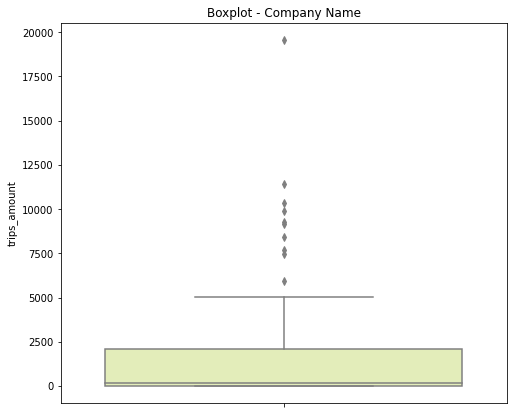

In [52]:
# menampilkan summary dari dataset company_name
print(df_company.describe())

# Membuat palet warna kuning
palette = sns.color_palette('YlGnBu')

# membuat boxplot
plt.figure(figsize=(8,7))
sns.boxplot(data=df_company, y='trips_amount', palette=palette)
plt.title('Boxplot - Company Name')
plt.show()

Dari informasi diatas terlihat bahwa `rata-rata trip keseluruhan perusahaan taksi` berkisar `2145 trips` untuk tanggal `15-16 November 2017` dengan nilai minimum dan nilai maksimum jumlah trip perusahaan taksi adalah `2 trips dan 19558 trips`. 

Selanjutnya mari kita buat grafik untuk mempermudah dalam membaca informasi.

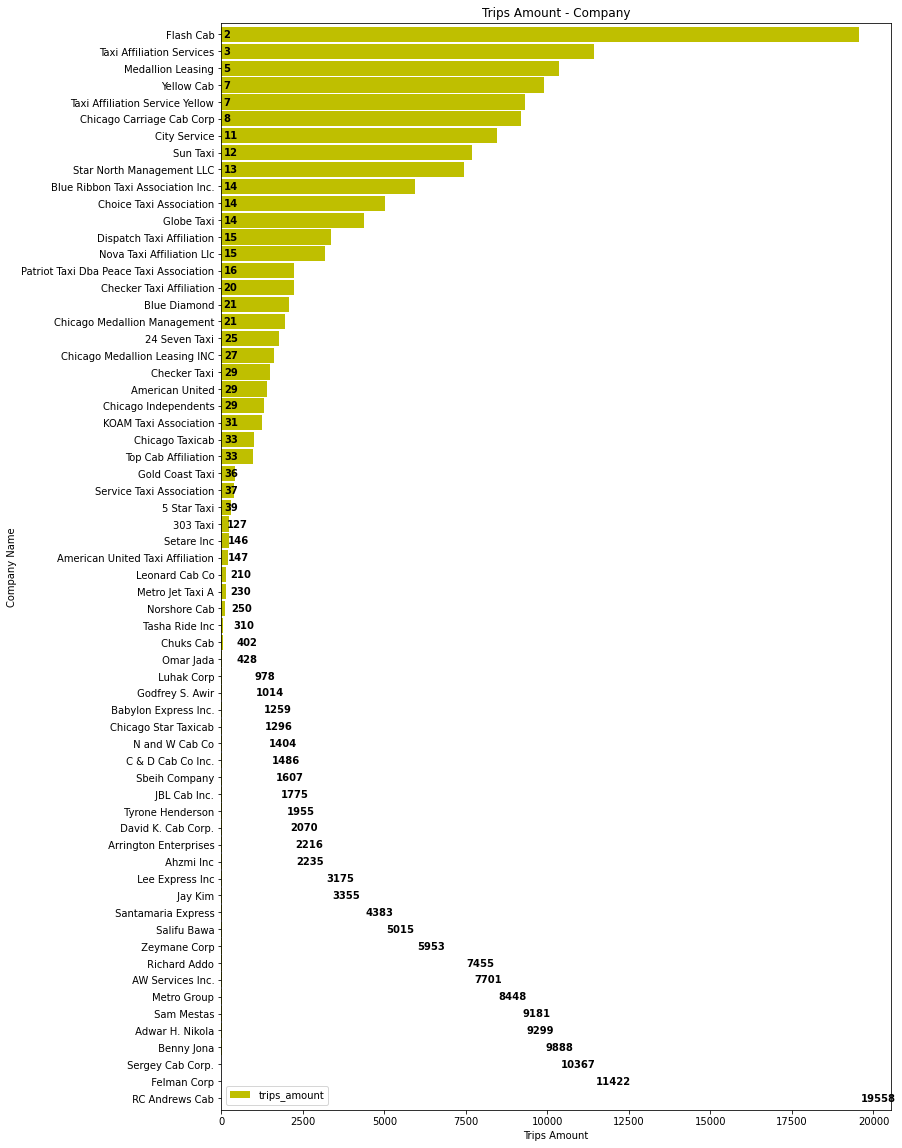

In [53]:
# Membuat grafik trip perusahaan taksi
ax = df_company.sort_values(by='trips_amount', ascending=True).plot(
    kind='barh',
    x='company_name',
    y='trips_amount',
    figsize=(12, 20),
    width=0.9,
    color='y'
)

# Membuat judul grafik
plt.title('Trips Amount - Company')

# Membuat label grafik
plt.xlabel('Trips Amount')
plt.ylabel('Company Name')

# Menambahkan anotasi
for i, v in enumerate(df_company['trips_amount']):
    ax.text(v + 50, i, str(v), color='black', va='center', fontsize=10, fontweight='bold')

# Menampilkan grafik
plt.show()

Dari grafik diatas terlihat bahwa perusahaan dengan jumlah trip terbanyak untuk tanggal `15-16 November 2017` adalah perusahaan `Flash Cab` kemudian `Taxi Affiliation Service` dan seterusnya. Sedangkan perusahaan yang paling rendah dalam jumlah tripnya adalah `RC Andrews Cab` kemudian `Felman Corp. Manuel Alonso` dan seterusnya.

#### Analisis Dataset Lokasi Dropoff

Mari kita cari tahu rangkuman dari dataset `Lokasi Dropoff` dengan menggunakan `describe` dan `boxplot`. 

       average_trips
count      94.000000
mean      599.478723
std      1714.555974
min         1.000000
25%        14.000000
50%        51.500000
75%       298.750000
max     10727.000000


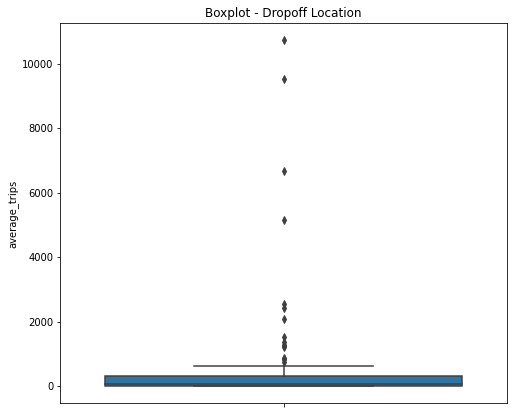

In [54]:
# menampilkan summary dari dataset dropoff_location
print(df_dropoff.describe())

# membuat boxplot
plt.figure(figsize=(8,7))
sns.boxplot(data=df_dropoff, y='average_trips')
plt.title('Boxplot - Dropoff Location')
plt.show()

Dari informasi diatas terlihat bahwa `rata-rata trip dari keseluruhan lokasi dropoff` berkisar `599 trips` untuk bulan `November 2017` dengan nilai minimum dan nilai maksimum rata-rata trip adalah `1 trips dan 10727 trips`. 

Selanjutnya mari kita ambil 10 lokasi dropoff dengan rata-rata trip terbanyak dari dataset yang kita punya.

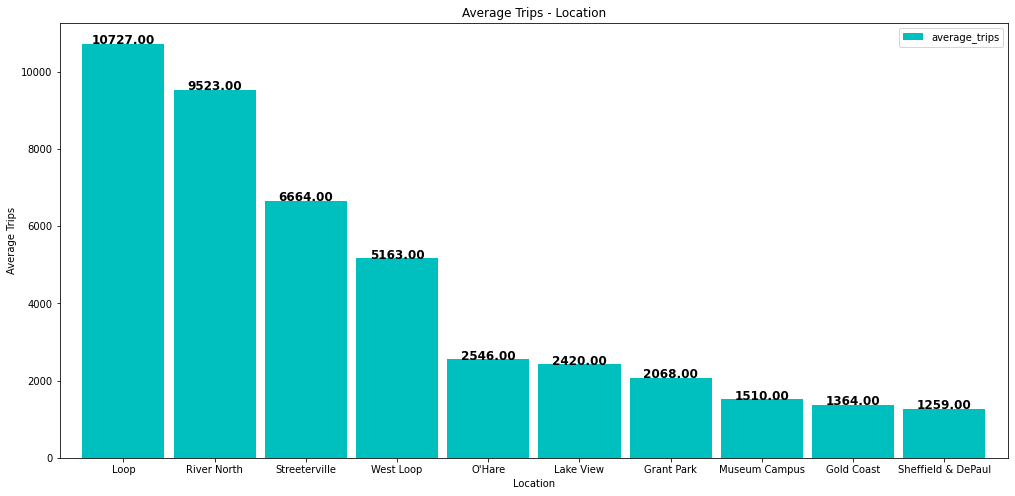

In [55]:
# Membuat grafik 10 wilayah yang sering dikunjungi
ax = df_dropoff.iloc[:10].sort_values(by='average_trips', ascending=False).plot(
    kind='bar',
    x='dropoff_location_name',
    y='average_trips',
    figsize=(17, 8),
    width=0.9,
    color='c',
    rot=0
)

# Membuat judul grafik
plt.title('Average Trips - Location')

# Membuat label grafik
plt.ylabel('Average Trips')
plt.xlabel('Location')

# Menambahkan anotasi untuk jumlah rata-rata perjalanan
for i, v in enumerate(df_dropoff.iloc[:10]['average_trips']):
    ax.text(i, v, f'{v:.2f}', horizontalalignment='center', fontsize=12, color='black', fontweight='bold')

# Menampilkan grafik
plt.show()

Dari grafik diatas terlihat bahwa lokasi dropoff dengan rata-rata jumlah trip terbanyak untuk bulan `November 2017` adalah `Loop` yaitu `10727 trip` kemudian `River North` yaitu `9523 trip` dan seterusnya. Sedangkan perusahaan yang paling rendah dalam rata-rata tripnya adalah `Sheffield & DePaul` kemudian `Gold Coast` dan seterusnya.

### Pengujian Hipotesis

Pada langkah ini kita akan menguji suatu hipotesis dimana hipotesisnya adalah "Durasi rata-rata perjalanan dari Loop ke Bandara Internasional O'Hare berubah pada hari-hari Sabtu yang hujan". Mari kita urai menjadi Hipotesis Nol dan Hipotesis Alternatif:
- Hipotesis Nol: Durasi rata-rata perjalanan dari Loop ke Bandara Internasional O'Hare `sama` pada hari-hari Sabtu yang hujan
- Hipotesis Alternatif: Durasi rata-rata perjalanan dari Loop ke Bandara Internasional O'Hare `berubah` pada hari-hari Sabtu yang hujan

Sebelum kita uji hipotesis bisa `hapus dulu outliers` yang ada pada kolom `duration seconds`, selain itu, sebelum menggunakan `ttest_ind` coba gunakan dulu `levene test` untuk mengetahui varians dari dua data sama atau tidak, dari hasil `levene test`, kita gunakan parameter `equal_var=True` pada `ttest_ind` jika varians sama, dan False jika sebaliknya. Terakhir kita bisa menguji hipotesis tersebut dengan menggunakan teknik `ttest_ind` yang ada pada library Scipy. 

Signifikansi Level yang umum digunakan sebesar` 5% (0.05)`, nilai ini digunakan untuk menguji `Hipotesis Nol`, jika `pvalue` pengujian kurang dari Signifikansi Level, `Hipotesis Nol ditolak`.

In [56]:
from scipy import stats as st

# 1. Menghapus outliers pada kolom duration_seconds
def remove_outliers(data):
    Q1 = data['duration_seconds'].quantile(0.25)
    Q3 = data['duration_seconds'].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    return data[(data['duration_seconds'] >= lower_bound) & (data['duration_seconds'] <= upper_bound)]

# Memfilter dataset weather untuk cuaca yang baik dan cuaca yang buruk
good_weather = remove_outliers(df_weather.query('weather_conditions == "Good"'))
bad_weather = remove_outliers(df_weather.query('weather_conditions == "Bad"'))

# 2. Melakukan Levene Test untuk menguji kesamaan varians
_, levene_pvalue = st.levene(good_weather['duration_seconds'], bad_weather['duration_seconds'])

# Besarnya signifikan level
alpha = 0.05

# 3. Pengujian hipotesis dengan memperhatikan varians
if levene_pvalue < alpha:
    equal_var = False  # Varians berbeda
else:
    equal_var = True   # Varians sama

# Melakukan t-test dengan parameter equal_var sesuai dengan hasil Levene Test
result = st.ttest_ind(good_weather['duration_seconds'], bad_weather['duration_seconds'], equal_var=equal_var)
pvalue = result.pvalue
print(f'Nilai p-value: {pvalue}')

if pvalue < alpha:
    print('Hipotesis Nol Ditolak')
else:
    print('Tidak Bisa Menolak Hipotesis Nol')

Nilai p-value: 2.3363796620667466e-09
Hipotesis Nol Ditolak


Hipotesis Nol Ditolak, sehingga Hipotesis Alternatif yang diterima bahwa `Durasi rata-rata perjalanan dari Loop ke Bandara Internasional O'Hare berubah pada hari-hari Sabtu yang hujan`.

### Kesimpulan Umum 

Dalam analisis di atas, kami telah membuat DataFrame dengan data dari website dan melakukan perbaikan kualitas data. Ini mencakup pencarian duplikat, penanganan nilai yang hilang, perubahan tipe data, dan transformasi nilai data menggunakan regular expression. Kami menggunakan `SQL` untuk mengumpulkan data spesifik dan terus melakukan `Exploratory Data Analysis (EDA)` dengan `Python`. Berikut adalah rangkuman temuan kami:

1. Ada dua perusahaan dengan nama `Yellow` yaitu `Taxi Affiliation Service Yellow` dan `Yellow Cab`, dengan masing-masing `29.213` dan `33.668` trip pada tanggal `1 - 7 November 2017`. Sementara perusahaan dengan nama `Blue` seperti `Blue Diamond` dan `Blue Ribbon Taxi Association Inc` memiliki masing-masing `6764` dan `17675` trip.

2. `Flash Cab` memiliki jumlah trip terbanyak, yaitu `64084` trip pada periode `1 - 7 November 2017`, sedangkan `Taxi Affiliation Services` hanya memiliki `37583` trip.

3. Rata-rata jumlah trip dari seluruh perusahaan taksi berkisar sekitar `2145` trip pada tanggal `15-16 November 2017`. Rentang nilai minimum dan maksimum perusahaan taksi adalah `2` trip dan `19558` trip.

4. Jumlah trip terbanyak pada tanggal `15-16 November 2017` adalah `Flash Cab` sementara `RC Andrews Cab` memiliki jumlah trip terendah.

5. Rata-rata trip dari seluruh lokasi dropoff berkisar sekitar `599` trip selama bulan November 2017. Rentang nilai minimum dan maksimum rata-rata trip adalah `1` trip dan `10727` trip.

6. Lokasi dropoff dengan rata-rata jumlah trip tertinggi selama bulan November 2017 adalah `Loop` sementara `Sheffield & DePaul` memiliki rata-rata trip terendah.

7. Pengujian hipotesis mengenai `Durasi rata-rata perjalanan dari Loop ke Bandara Internasional O'Hare sama pada hari-hari Sabtu yang hujan` menolak hipotesis nol, sehingga menerima hipotesis alternatif bahwa `Durasi rata-rata perjalanan dari Loop ke Bandara Internasional O'Hare berubah pada hari-hari Sabtu yang hujan`.